In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from utils import plot_contour, gridsearch_heatmap, compare_results
plt.rcParams['figure.figsize'] = [10, 10]
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import datetime as dt
from pathlib import Path
import sys
sys.path.insert(0, "..") 

from src.visualization import visualize
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve

<font size="10">Doorlooptijd facturen Moore DRV</font>

<font size="8">Project benadering</font>

Dit project is erop gericht om voor Moore DRV middels machine learning te kunnen voorspellen of een factuur binnen de betaal termijn van de factuur betaald wordt. Het project houdt in grote lijnen de structuur van de CRISP-DM methodiek aan welke is ontworpen voor Data Science vraagstukken. Hieronder is de CRISP-DM methodiek gevisualiseerd.

<img src=https://www.researchgate.net/profile/Vernon-Dsouza/publication/326235288/figure/fig1/AS:645518493495296@1530915010595/CRISP-DM-Model-Taylor-2017.png height="400">

<font size="8">1. Business understanding</font>

<font size="6">1.1 Context Moore DRV</font>

Moore DRV is een accountantskantoor met twaalf vestigingen verspreid in de regio Zuidwest-Nederland. Als accountantskantoor biedt het bedrijf een breed scala aan diensten voor haar klanten. Hierbij kan gedacht worden aan ondersteuning bij boekhoudkundige vragen, advies over fiscale zaken, het opmaken en/of het controleren van jaarrekeningen.

DRV is in veel opzichten een groeiende organisatie. Uit de jaarcijfers van 2019 blijkt dat de laatste vijf jaren niet alleen de omzet is toegenomen, maar ook het aantal FTE. De omzet bedroeg in 2019 bijna 60 miljoen, wat werd gerealiseerd door 600 medewerkers. Ter vergelijking: in 2015 was de omzet 40 miljoen en bedroeg het aantal medewerkers 358. De slogan van DRV luidt “Stilletjes een van de beste kantoren van Nederland”. Kwaliteit en clienttevredenheid zijn de kernwaarden van DRV en staan hoog in het vaandel. 

<font size="6">1.2 Bedrijfsdoel Moore DRV</font>

Met 12.000 particulieren en 12.000 zakelijke klanten bediend Moore DRV een groot aantal klanten. Deze klanten ontvangen op regelmatige basis facturen vanuit Moore DRV waarin het voltooide werk in rekening wordt gebracht. Op de Financiële afdeling van Moore DRV leeft het gevoel dat een aannemelijk deel van de facturen niet binnen de betaaltermijn betaald wordt. De doelstelling van Moore DRV voor dit project is dan ook om inzicht te krijgen in de factuurdata en om te kunnen voorspellen welke facturen wel of niet binnen de betaaltermijn kunnen worden betaald. 

De Data science doelstelling is uiteraard om zo nauwkeurig mogelijk te kunnen voorspellen of een factuur wel of niet op tijd betaald wordt binnen de betaal termijn. 

<font size="6">1.3 Aannames en beperkingen</font>

De opgehaalde klantdata is actueel terwijl de facturen enige historie bevat. Hierdoor zou het zo kunnen zijn dat de klant op het moment van facturen in een andere sector of klantgroep zat als er getoond word.  




<font size="10">2. Data Understanding</font>

<font size="6">2.1 Data verzameling</font>

Moore DRV heeft met betrekking tot het doel van dit project een dataset ter beschikking gesteld aan Geert Jansen, de student aan de Hogeschool Utrecht en tevens Data Analist bij DRV.
De dataset is afkomstig uit het datawarehouse van Moore DRV en is daar middels een SQL statement opgehaald. De data in het warehouse is afkomst uit Navision het ERP pakket van Moore DRV. 

In het SQL statement worden verschillende gegevens uit de facturatie tabel en de klant tabel opgehaald. De klant en facturatie worden gekoppeld door de een koppeling te maken op klantnummer. In het SQL statement worden al verschillend keuzes gemaakt om de data te selecteren, namelijk:
-	Er worden enkel facturen meegenomen vanaf 2019, deze keuze is gemaakt om geen gedateerde data mee te nemen en de dataset niet te groot te laten worden.
-	De factuur moet betaald zijn, wanneer dit niet het geval is kan er uiteraard niet worden bepaald of de factuur wel of niet op tijd betaald is.
-	Memoriaalboekingen en bankboekingen worden niet meegenomen de dataset, dit zijn administratieve boekingen en vervuilen daarmee de dataset.



<font size="6">2.2 Data beschrijving</font>

In onderstaande code wordt de date ingeladen welke is opgaald is middels het SQL statement en in CSV formaat is opgeslagen. Voordat de data getoond wordt zullen de komen Welke Datum's betatten eerst in het juiste formaat worden gezet. Vervolgens worden de kolommen getoond deze zijn in te delen in 3 soorten. 
1. Informatie kolommen, deze zullen niets toevoegen aan het model maar zijn wel belangrijk om inzicht in de data te krijgen in dit hoofdstuk. 
Factuurnummer, Payment Terms, Global Dimension 1 code, Global Dimension 2 code, Factuurdatum, Velrloopdatum, Sluitdatum, Betaaltermijn en DagenOpen
2. Features, Dit zijn de kolommen welke als featrues zullen worden gebruikt om de voorspelling op te baseren.
Contact Type, Cusomer Posting Group, SBI Sector, Elec. factureren, GenormaliseerdBedrag, MaandFactuur,
3. Target, Dit is de kolom OptijdBetaald en dit is de te voorspellen waarden.

Een aantal kolommen zijn niet duidelijk, deze zullen hieronder verder toegelicht woren:
- Contact Type > Deze kolom geeft aan of het een particulieren of zakelijke klant betreft.
- Customer Posting Group > Deze kolom geeft aan wat voor soort klant het betreft, dit zal vaak deb ofwel debiteur zijn.
- Global Dimension 1 Code > Aan welke bedrijf ofwel onderdeel van Moore DRV is de klant gekoppeld.
- Global Dimension 2 code > Aan welke vestiging van het bedrijf van DRV is de klant gekoppeld.
- SBI Sector > SBI staat voor Standaard Bedrijfsindeling en is er voor gemaakt om bedrijven te kunnen verdelen in verschillende sectoren.
- Elec. factrureren > Dit geeft aan of de klant wel of niet electronisch de facturen wil ontvangen, dit kan van invloed zijn op de betaal termijn.
- GenormalisseerdBerdag > Deze kolom geeft de hoogte van het factuur bedrag aan, deze waarde is al genormaliseerd in de brondata.

In [2]:
datafolder = Path("../data/raw")
data = pd.read_csv(datafolder / "Data csv - 17-1-2022.csv")

data['Factuurdatum'] = pd.TimedeltaIndex(data['Factuurdatum'], unit='d') + dt.datetime(1899,12,30) 
data['Verloopdatum'] = pd.TimedeltaIndex(data['Verloopdatum'], unit='d')+ dt.datetime(1899,12,30) 
data['Sluitdatum'] = pd.TimedeltaIndex(data['Sluitdatum'], unit='d') + dt.datetime(1899,12,30) 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116478 entries, 0 to 116477
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Factuurnummer            116478 non-null  object        
 1   Global Dimension 2 Code  116478 non-null  object        
 2   Contact Type             116478 non-null  int64         
 3   Payment Terms Code       116478 non-null  object        
 4   Customer Posting Group   116478 non-null  object        
 5   Global Dimension 1 Code  116478 non-null  object        
 6   Factuurdatum             116478 non-null  datetime64[ns]
 7   SBI Sector               105110 non-null  object        
 8   elec. factureren         116478 non-null  int64         
 9   Maand                    116478 non-null  int64         
 10  GenormalisserdBedrag     116478 non-null  float64       
 11  Verloopdatum             116478 non-null  datetime64[ns]
 12  Sluitdatum      

In [4]:
data.head(5)

,Factuurnummer,Global Dimension 2 Code,Contact Type,Payment Terms Code,Customer Posting Group,Global Dimension 1 Code,Factuurdatum,SBI Sector,elec. factureren,Maand,GenormalisserdBedrag,Verloopdatum,Sluitdatum,Betaaltermijn,DagenOpen,OptijdBetaald
0,AA21-005812,AABZ,0,14 DAGEN,DEB,AA,2021-02-04,94,0,2,-0.321646,2021-02-18,2021-03-04,14,28,0
1,AA21-010236,AAGO,0,14 DAGEN,DEB,AA,2021-03-01,64,1,3,-0.321646,2021-03-15,2021-04-19,14,49,0
2,AA20-004861,AAMB,0,14 DAGEN,DEB,AA,2020-01-31,47,0,1,-0.321646,2020-02-14,2020-03-11,14,40,0
3,AA20-012411,AAGO,0,14 DAGEN,DEB,AA,2020-03-24,70,1,3,-0.321176,2020-04-07,2020-04-14,14,21,0
4,AA21-038194,AAOB,0,14 DAGEN,DEB,AA,2021-09-23,41,0,9,-0.321176,2021-10-07,2021-10-06,14,13,1


In [5]:
data["Contact Type"].mean

<bound method Series.mean of 0         0
1         0
2         0
3         0
4         0
         ..
116473    0
116474    0
116475    0
116476    0
116477    0
Name: Contact Type, Length: 116478, dtype: int64>

<font size="6">2.3 Data verkenning</font>

<font size="5">2.3.1 Verkenning per soort</font>

- verloop aantal facturen

Het verloop van het aantal facturen heeft een bepaald seizoensverloop in zich, uit onderstaande illustraties is te halen dat er met name in zomermaanden augutus en september minder wordt facuren worden verstuurd dan in de overige maanden. Het aantal fucturen lijkt in voor de geselecteerde periode geen grote toenamen of afnamen te vertonen. Daarnaast kan worden gezien dat er op de 1ste van de maand en vanaf halverwegen de maand de meeste facturen verstuurd worden, dit heeft geen verdere invloed op het model maar is wel goed om te weten. 

<AxesSubplot:xlabel='Maand', ylabel='Aantal facturen'>

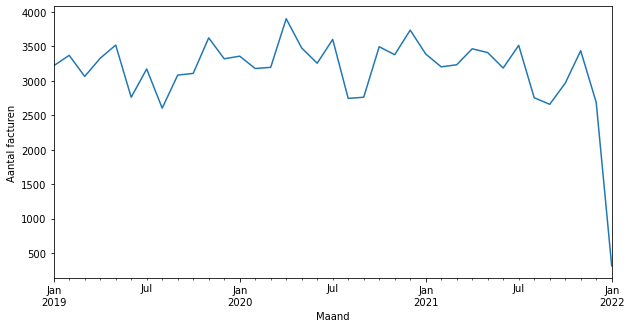

In [6]:
data['month_year'] = pd.to_datetime(data['Factuurdatum']).dt.to_period('M')
MothCount = data.groupby('month_year')["Factuurnummer"].count()
MothCount.plot(kind = 'line',ylabel='Aantal facturen', xlabel='Maand', figsize=(10, 5))

<AxesSubplot:xlabel='Dag', ylabel='Aantal facturen'>

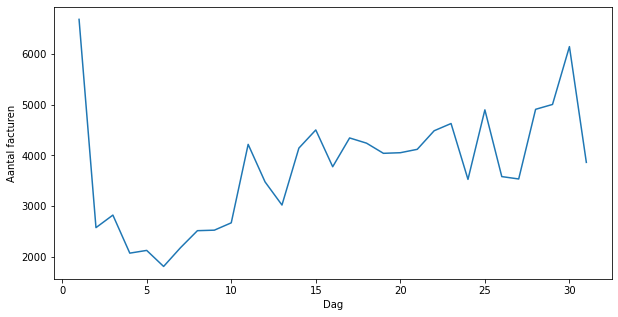

In [7]:
data['Factuur_Day'] = data['Factuurdatum'].dt.day
DayCount = data.groupby('Factuur_Day')["Factuurnummer"].count()
DayCount.plot(kind = 'line',ylabel='Aantal facturen', xlabel='Dag', figsize=(10, 5))

Vestingen
- Aantal per vesting.

De vestigingen beginnend met AA staan voor de vestigeingen welke gekoppeld zijn aan het bedrijf Moore DRV, deze vestigingen hebben de meeste klanten en daarmee dus ook de meeste facturen. Er zitten verschillen tussen de vestigingen en de verhouding of iets wel of niet optijd betaald is, wellicht is de vestig dus een intressante parameter voor het model.

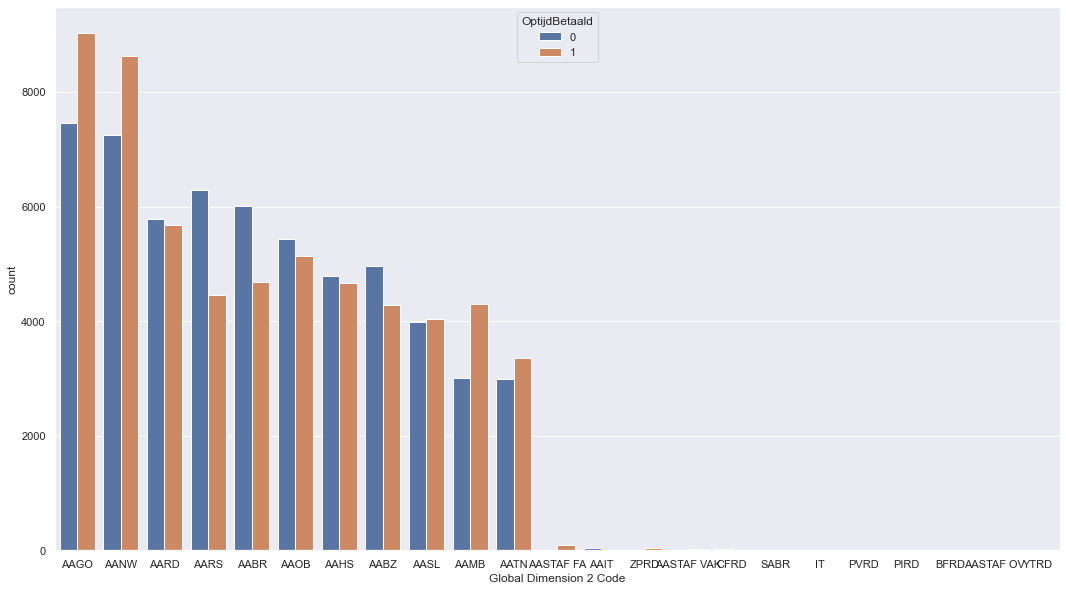

In [8]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="Global Dimension 2 Code",hue = "OptijdBetaald", data=data,order=data['Global Dimension 2 Code'].value_counts().index)

- Betaal gedrag

Het aantal wel of niet optijd betaalde facturen is ongeveer gelijk, dit is mooi startpunt voor ons model. Daarnaast is te zien dat het grootste deel van de optijd betaalde facuren op dag 13 of 14 wordt betaald. Net als voor vestiging verschild verhouding wel of niet optijd betaald per maand, dit maakt dat dit ook een interessante parameter kan zijn.

Wanneer de gemiddelde van de overige parametrs voor zowel de groep facturen die op tijd zijn betaald als voor de groep welke dat niet kan worden gecocludeerd dat:

- Zakelijke Klanten vaker optijd betalen.
- Klanten met electonisch factureren niet altijd sneller betalen als klant zonder electronisch factureren. 
- Hoe lager het factuur bedrag, hoe groter de kans dat de facuur optijd betaald wordt. 

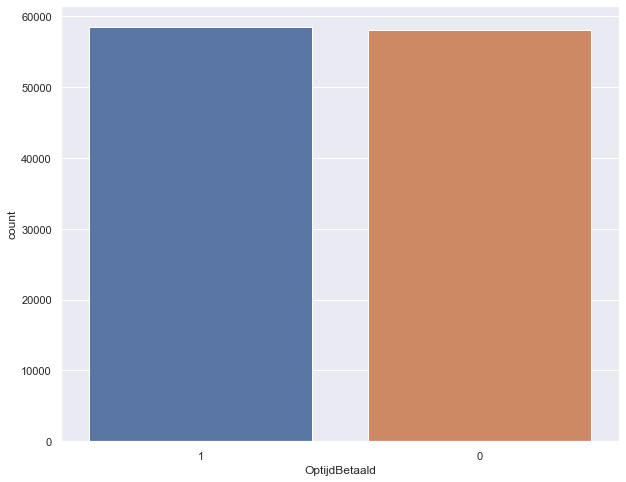

In [9]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x="OptijdBetaald", data=data,order=data['OptijdBetaald'].value_counts().index)

<AxesSubplot:xlabel='Dagen open', ylabel='Aantal facturen'>

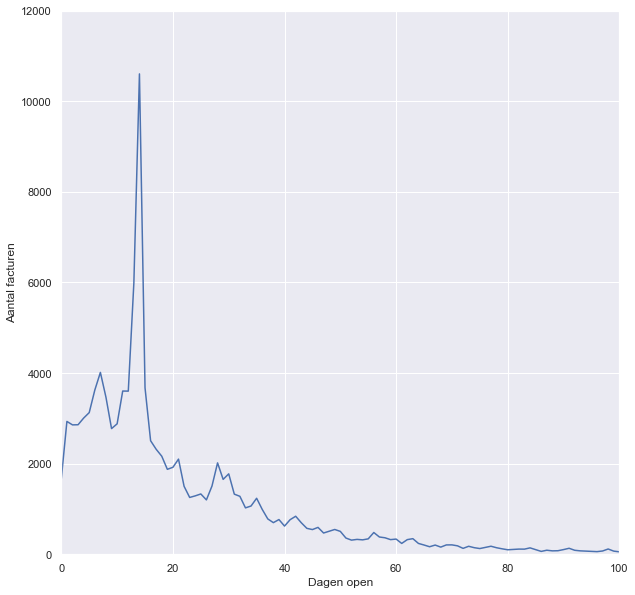

In [10]:
MothCount = data.groupby('DagenOpen')["Factuurnummer"].count()
MothCount.plot(kind = 'line',ylabel='Aantal facturen', xlabel='Dagen open', figsize=(10, 10),xlim=(0,100),ylim=(0,12000))

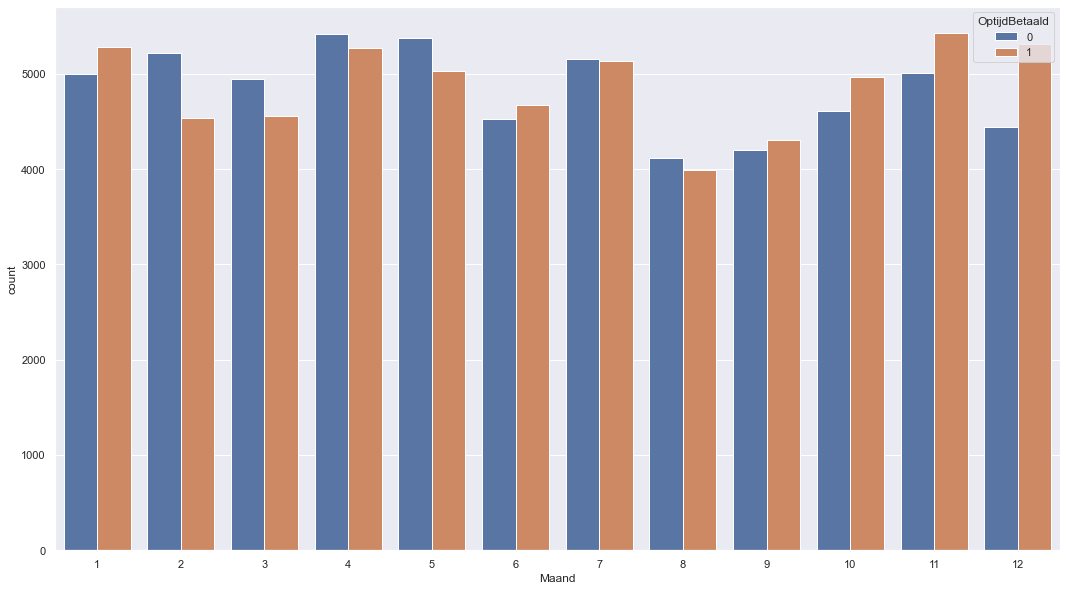

In [11]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="Maand",hue = "OptijdBetaald", data=data)

In [12]:
data.groupby('OptijdBetaald').mean()

,Contact Type,elec. factureren,Maand,GenormalisserdBedrag,Betaaltermijn,DagenOpen,Factuur_Day
OptijdBetaald,,,,,,,
0,0.062175,0.682094,6.329903,-0.132938,14.579222,46.882477,17.341211
1,0.112411,0.596042,6.532208,-0.148326,14.870604,9.217690,17.521329


SBI Code

Het aantal facuren per sbi code loopt flink uiteen, om een beeld te vormen hieronder de drie sectoren waarna de meeste facturen worden verstuurd. Ook voor deze parameter lijkt verschil te zitten in de verdelingen tussen wel en niet betaalde facturen, waardoor ook deze featrue interssant kan zijn. 

1. 64 > Financiële instellingen (geen verzekeringen en pensioenfondsen)
2. 46 > Groothandel en handelsbemiddeling (niet in auto’s en motorfietsen)
3. 47 > Detailhandel (niet in auto’s)

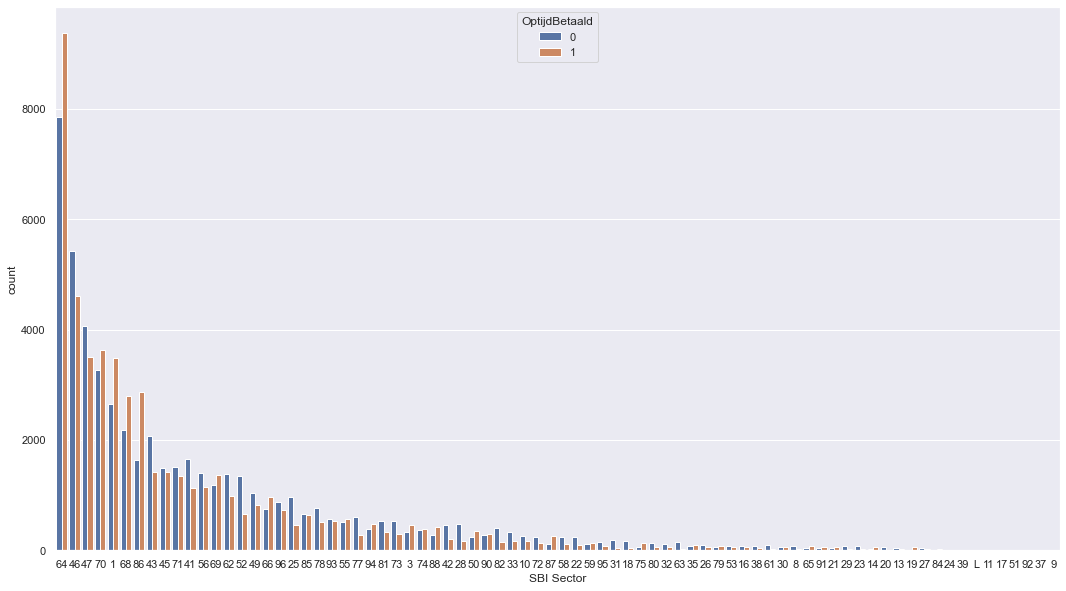

In [13]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="SBI Sector",hue = "OptijdBetaald", data=data,order=data['SBI Sector'].value_counts().index)

- Contact type

Er is een aanzienlijk verschil tussen het aantal facturen naar 0(zakelijke) en 1(particulieren) klanten. Ook de verdeling tussen de het wel of niet optijd betalen en de type klant lijkt niet gelijk, zakelijke klanten betalen vaker niet op tijd dan wel optijd voor particulieren is dit precies anderzom. 

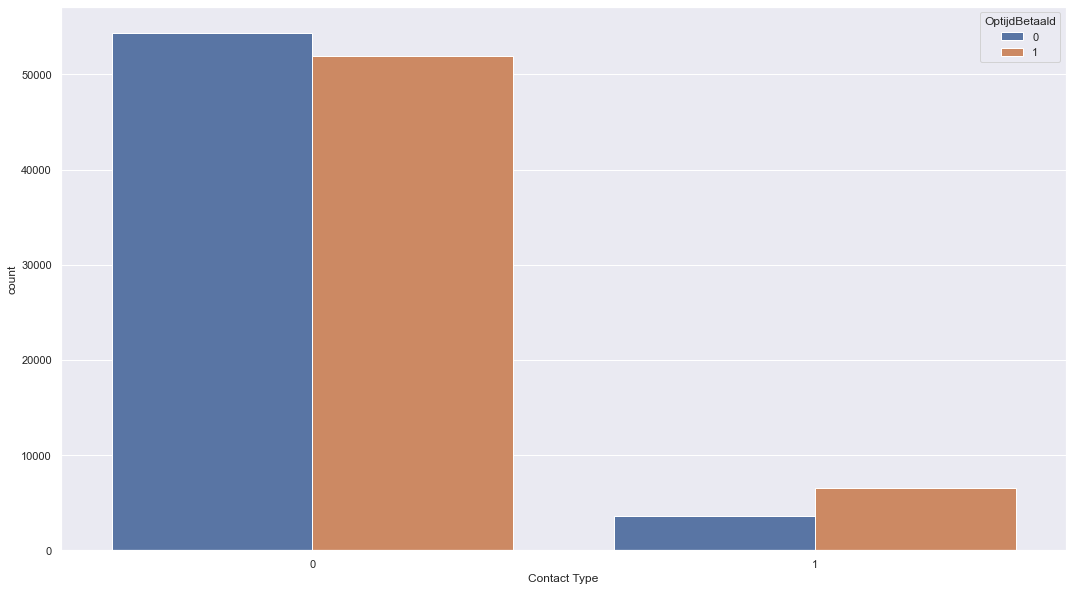

In [14]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="Contact Type",hue = "OptijdBetaald", data=data,order=data['Contact Type'].value_counts().index)

- Contact factuurtype

Er worden meer facuren gestuurd naar klanten met electonisch facturen als klant zonder deze instelling. Ook voor deze feater geld dat de verdeling van elkaar afwijken. De klanten zonder eletronisch factureren betalen vaker op tijd dan niet optijd, voor de klanten met elecotonisch factureren is dit precies anderzom.

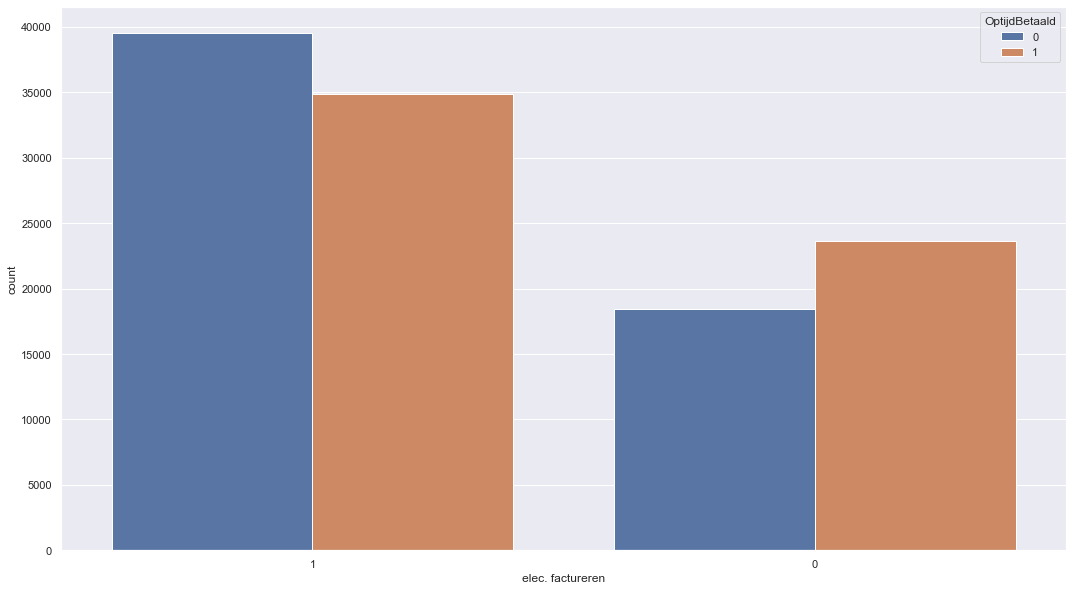

In [15]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="elec. factureren",hue = "OptijdBetaald", data=data,order=data['elec. factureren'].value_counts().index)

<font size="6">2.4 Data kwaliteit</font>

- onbekende waarden

In onderstaande illustratie is te zien dat er een een waarde is waarde is waar relatief veel missende waardes zijn namelijk SBI-code. De reden hiervan is goed te verklaren, een particiculier is namelijk niet in te delen in een sector omdat het geen bedrijf betreft. Er zal dus goed gekeken moeten worden welke invloed dit heeft op het model.

<AxesSubplot:xlabel='Kolommen', ylabel='Aaantal NA'>

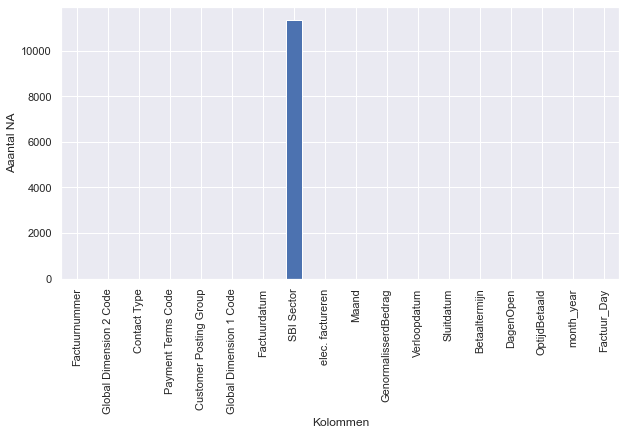

In [16]:
ISna = data.isna().sum() 
ISna.plot(kind = 'bar',ylabel='Aaantal NA', xlabel='Kolommen', figsize=(10, 5))

<font size="10">3 Data prepareren</font>


<font size="6">3.1 Data selecteren</font>

In onderstaande fase worden alle kolommen welke niet noodzakelijk zijn voor het model verwijderd, zo blijven er alleen featrus en de target over. 

In [17]:
data = data.drop(['Factuurnummer','Global Dimension 2 Code', 'Payment Terms Code','Customer Posting Group','Global Dimension 1 Code','Factuurdatum',
'Verloopdatum','Sluitdatum','Betaaltermijn','DagenOpen','month_year','Factuur_Day','SBI Sector'], axis = 1)

data = data.rename(columns={'OptijdBetaald': 'target'})

data

,Contact Type,elec. factureren,Maand,GenormalisserdBedrag,target
0,0,0,2,-0.321646,0
1,0,1,3,-0.321646,0
2,0,0,1,-0.321646,0
3,0,1,3,-0.321176,0
4,0,0,9,-0.321176,1
...,...,...,...,...,...
116473,0,0,1,0.415883,0
116474,0,1,2,0.415883,1
116475,0,1,11,0.416117,1
116476,0,1,1,0.416117,1


<font size="6">3.2 Train en test split</font>

De data wordt in onderstaande fase gesplits in een train en een test set. Zoals in voorgaande hoofdstuk al duidelijk is geworden bevat de data set 116.478 rijen. Door de grote van deze dateset is er behoordelijk wat flexibiltiet om de grote van de train en de test bepalen. Er is voor gekozen om de train test verdeling van 80/20 aan te houden op basis van onderstaande bron.

Er gekozen om de verdeling door de train_test_split module van Sklearn te leten doen, deze split de dataset random waardoor er minder kans is op voorkeuren in de data.

<img src=https://www.baeldung.com/wp-content/uploads/sites/4/2021/01/split_dataset-n-on-split.png height="400">

(A. Aylin Tokuç,2021)

In [18]:
from sklearn.model_selection import train_test_split
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
data.shape , X_train.shape, X_test.shape,y_train.shape,y_test.shape

((116478, 5), (93182, 4), (23296, 4), (93182,), (23296,))


<font size="6">3.3 Data prepareren</font>

In onderstaande fase wordt de datasets gereed gemaakt om op te trainen en testen. De kolommen SBI Sector en Maand bevatten catagorische kenmerken welke geen specifieke voorkeursvolgorde hebben daardoor kan het model niet omgaam met deze waarden. De oplossing welke is gekozen is one hot encoding, hierdoor worden deze kolommen verdeeld over het aantal unieke waarde welke in deze kolomm zit.

Als laatste worden de datasets omgezet naat NuMPy-arrays, deze zijn sneller, compacter en makkelijker te optimaliseren. 

In [19]:
#X_train = pd.get_dummies(X_train, columns = ['Maand','SBI Sector'])
#X_test = pd.get_dummies(X_test, columns = ['Maand','SBI Sector'])

In [20]:
X_train = pd.get_dummies(X_train, columns = ['Maand'])
X_test = pd.get_dummies(X_test, columns = ['Maand'])

In [21]:
data.shape , X_train.shape, X_test.shape,y_train.shape,y_test.shape

((116478, 5), (93182, 15), (23296, 15), (93182,), (23296,))

In [22]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

<font size="10">4 Modeleren</font>

<font size="6">4.1 baseline</font>


- Eerste model

keuze uitleggen

In [23]:
import tensorflow as tf 
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist, mnist
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
from utils import *

In [24]:
result = {}
score = {}

In [43]:
%%time
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
from tensorflow.keras.layers import Reshape
tf.random.set_seed(42)
model = Sequential([
    #Rescaling(1./255),
    #Flatten(),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['base'] = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[early_stop], verbose = 1)
score['base']=model.evaluate(X_test, y_test)


728/728 [==============================] - 1s 1ms/step - loss: 0.6860 - accuracy: 0.5496
Wall time: 6.64 s


In [44]:
%%time
tf.random.set_seed(42)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model = Sequential([
    #Rescaling(1./255),
    #Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['hugedense'] = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), 
                            callbacks=[early_stop],verbose = 1)
score['hugedense']=model.evaluate(X_test, y_test)

728/728 [==============================] - 2s 3ms/step - loss: 0.7027 - accuracy: 0.5375
Wall time: 30.6 s


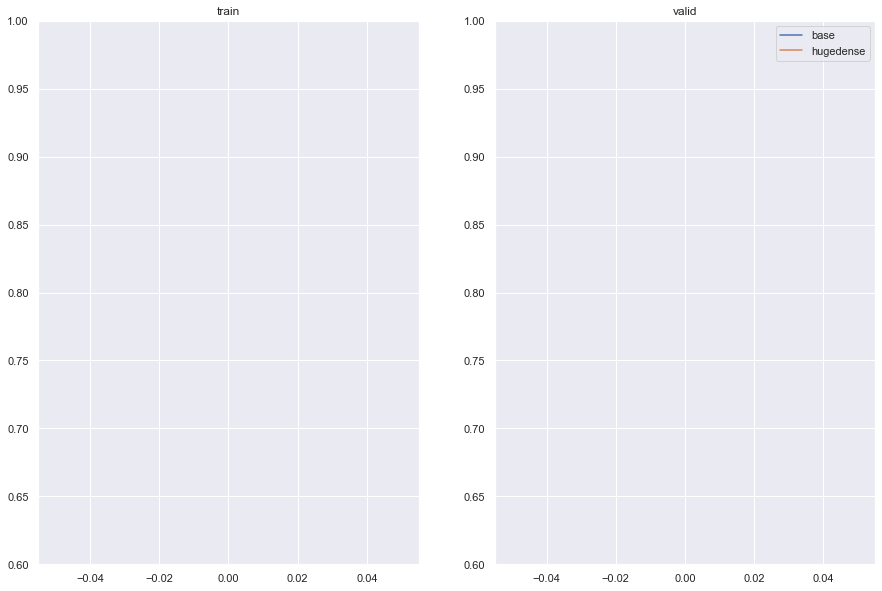

In [46]:
plot_results(result,ymin=0.6, ymax=1, yscale='linear')

In [25]:
from src.models import hypermodel

datafile = Path(".") / "data/processed/data.npy"
local_dir = Path("./models/ray")
logbase = Path(".") / "logs"
datafile.exists()

config = {
    "datafile" : datafile.absolute(),
    "units" : 64,
    "dense_layers" : 2,
    "activation" : "relu", 
    "optimizer" : "Adam", 
    "epochs" : 30,
    "local_dir" : local_dir.absolute(),
    "log_dir" : logbase.absolute() / "hypertuned",
    "samples" : 5,
}

model = hypermodel.hypermodel(config)

# build will happen automatically when you feed the model a batch of data
# however, to show the summary, we either need to do that,
# or we can call .build() on the model.
# do you understand why the model needs the shape information to build the model?
model.build(input_shape=X_train[1:].shape) 
model.summary()

Model: "hypermodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  1024      
                                                                 
 dense_1 (Dense)             multiple                  4160      
                                                                 
 dense_2 (Dense)             multiple                  4160      
                                                                 
 dense_3 (Dense)             multiple                  65        
                                                                 
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


In [27]:
from ray import tune

In [31]:
config = {
    "datafile" : datafile.absolute(),
    "units" : tune.qrandint(16, 128, 8),
    "dense_layers" : tune.randint(2,6), 
    "activation" : "relu", 
    "optimizer" : "Adam", 
    "epochs" : 30,
    "local_dir" : local_dir.absolute(),
    "log_dir" : logbase.absolute() / "hypertuned",
    "samples" : 10,
    "grace_period" : 3,
    "modulepath" : Path("../src")
}
config

{'datafile': WindowsPath('c:/Users/JansenG/ml-21-master/Project ML-21-Geert Jansen/notebooks/data/processed/data.npy'),
 'units': <ray.tune.sample.Integer at 0x271e13ddf10>,
 'dense_layers': <ray.tune.sample.Integer at 0x271e13ddac0>,
 'activation': 'relu',
 'optimizer': 'Adam',
 'epochs': 30,
 'local_dir': WindowsPath('c:/Users/JansenG/ml-21-master/Project ML-21-Geert Jansen/notebooks/models/ray'),
 'log_dir': WindowsPath('c:/Users/JansenG/ml-21-master/Project ML-21-Geert Jansen/notebooks/logs/hypertuned'),
 'samples': 10,
 'grace_period': 3,
 'modulepath': WindowsPath('../src')}

In [32]:
from src.models import train_model
analysis = train_model.hypertune(iterations=1, config=config)

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [47]:
from tensorflow.keras.layers import Dense

x = Dense(1)(X_train)
X_train.shape, x.shape

((93182, 15), TensorShape([93182, 1]))

In [ ]:
x = Dense(30)(X_train)
X_train.shape, x.shape

((93182, 93), TensorShape([93182, 30]))

<font size="6">4.2 Model 1</font>

<font size="6">4.3 Model 2</font>

<font size="10">5. Evaluatie & implementatie</font>

<font size="6">5.1 Nauwkeurigheid, recall, matrix etc. </font>

<font size="6">4.2 Model 1</font>

<font size="6">5.3 Implementatie</font>

In [ ]:
datafolder = Path("../data/raw")
df = pd.read_csv(datafolder / "Data csv - 17-1-2022.csv")


df['Factuurdatum'] = pd.TimedeltaIndex(df['Factuurdatum'], unit='d') + dt.datetime(1899,12,30) 
df['Verloopdatum'] = pd.TimedeltaIndex(df['Verloopdatum'], unit='d')+ dt.datetime(1899,12,30) 
df['Sluitdatum'] = pd.TimedeltaIndex(df['Sluitdatum'], unit='d') + dt.datetime(1899,12,30) 

df

,Factuurnummer,Global Dimension 2 Code,Contact Type,Payment Terms Code,Customer Posting Group,Global Dimension 1 Code,Factuurdatum,SBI Sector,elec. factureren,Maand,GenormalisserdBedrag,Verloopdatum,Sluitdatum,Betaaltermijn,DagenOpen,OptijdBetaald
0,AA21-005812,AABZ,0,14 DAGEN,DEB,AA,2021-02-04,94,0,2,-0.321646,2021-02-18,2021-03-04,14,28,0
1,AA21-010236,AAGO,0,14 DAGEN,DEB,AA,2021-03-01,64,1,3,-0.321646,2021-03-15,2021-04-19,14,49,0
2,AA20-004861,AAMB,0,14 DAGEN,DEB,AA,2020-01-31,47,0,1,-0.321646,2020-02-14,2020-03-11,14,40,0
3,AA20-012411,AAGO,0,14 DAGEN,DEB,AA,2020-03-24,70,1,3,-0.321176,2020-04-07,2020-04-14,14,21,0
4,AA21-038194,AAOB,0,14 DAGEN,DEB,AA,2021-09-23,41,0,9,-0.321176,2021-10-07,2021-10-06,14,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116473,AA19-000736,AABR,0,14 DAGEN,DEB,AA,2019-01-10,70,0,1,0.415883,2019-01-24,2019-02-06,14,27,0
116474,AA21-008340,AASL,0,14 DAGEN,DEB,AA,2021-02-25,46,1,2,0.415883,2021-03-11,2021-03-10,14,13,1
116475,AA21-046653,AABR,0,14 DAGEN,DEB,AA,2021-11-22,62,1,11,0.416117,2021-12-06,2021-11-25,14,3,1
116476,AA19-003699,AARS,0,14 DAGEN,DEB,AA,2019-01-28,46,1,1,0.416117,2019-02-11,2019-02-11,14,14,1


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
input = Input(shape=X_train.shape[1:])
x = Dense(30, activation='relu', name="my_secret_first_hidden_layer")(input)
output = Dense(1)(x)

model = Model(inputs=[input], outputs=[output])
model.summary()